# Superoperator tools

In this notebook we explore the submodules of `operator_tools` that enable easy manipulation of the various quantum channel representations.

To summarize the functionality:

- vectorization and conversions between different representations of quantum channels
- apply quantum operations
- compose quantum operations
- validate that quantum channels are physical
- project unphysical channels to physical channels

## Brief motivation and introduction

Perfect gates in **reversible classical computation** are described by permutation matrices, e.g. the [Toffoli gate](https://en.wikipedia.org/wiki/Toffoli_gate), while the input states are vectors. A noisy classical gate could be modeled as a perfect gate followed by a noise channel, e.g. [binary symmetric channel](https://en.wikipedia.org/wiki/Binary_symmetric_channel), on all the bits in the state vector.

Perfect gates in **quantum computation** are described by unitary matrices and states are described by complex vectors, e.g.

$$|\psi\rangle = U |\psi_0\rangle$$

Modeling **noisy quantum computation** often makes use of [mixed states](https://en.wikipedia.org/wiki/Density_matrix) and quantum operations or quantum noise channels.

Interestingly there are a number of ways to represent quantum noise channels, and depending on your task some can be more convenient than others. The simplest case to illustrate this point is to consider a mixed initial state $\rho$ undergoing unitary evolution

$$\rho' = U \rho U^\dagger$$

The fact that the unitary has to act on both sides of the initial state means it is a [*superoperator*](https://en.wikipedia.org/wiki/Superoperator), that is an object that can act on operators like the state matrix. 



It turns out using a special matrix multiplication identity we can write this as

$$|\rho'\rangle \rangle = \mathcal U |\rho\rangle\rangle$$

where $\mathcal U = U^*\otimes U$ and $|\rho\rangle\rangle =  {\rm vec}(\rho)$. The nice thing about this is it looks like the pure state case. This is because the operator (the state) has become a vector and the superoperator (the left right action of $U$) has become an operator. 


**More information**  
Below we will assume that you are already an expert in these topics. If you are unfamiliar with these topics we recommend the following references

- chapter 8 of [Mike_N_Ike] which is on *Quantum noise and quantum operations*. 
- chapter 3 of John Preskill's lecture notes [Physics 219/Computer Science 219](http://www.theory.caltech.edu/people/preskill/ph219/chap3_15.pdf)
- the [file](../superoperator_representations.rst) `/docs/superoperator_representations.md` 
- for an intuitive but advanced treatment see [GRAPTN]



| [Mike_N_Ike] *Quantum Computation and Quantum Information*.  
|     Michael A. Nielsen & Isaac L. Chuang.  
|     Cambridge: Cambridge University Press (2000).  


| [GRAPTN] *Tensor networks and graphical calculus for open quantum systems*.  
|     Christopher Wood et al.  
|     Quant. Inf. Comp. 15, 0579-0811 (2015).  
|     https://arxiv.org/abs/1111.6950  

## Conversion between different descriptions of quantum channels

We intentionally chose not to make quantum channels python objects with methods that would automatically transform between representations. 

The functions to convert between different representations are called things like `kraus2chi`, `kraus2choi`, `pauli_liouville2choi` etc.

This assumes the user does not do silly things like input a Choi matrix to a function `chi2choi`.

In [1]:
import numpy as np
from pyquil.simulation.matrices import I, X, Y, Z, H, CNOT

Define some channels

In [2]:
def amplitude_damping_kraus(p):
    Ad0 = np.asarray([[1, 0], [0, np.sqrt(1 - p)]])
    Ad1 = np.asarray([[0, np.sqrt(p)], [0, 0]])
    return [Ad0, Ad1]

def bit_flip_kraus(p):
    M0 = np.sqrt(1 - p) * I
    M1 = np.sqrt(p) * X
    return [M0, M1]

Define some states

In [3]:
one_state = np.asarray([[0,0],[0,1]])
zero_state = np.asarray([[1,0],[0,0]])
rho_mixed = np.asarray([[0.9,0],[0,0.1]])

### vec and unvec 

We can vectorize i.e. `vec` and unvec matrices.

We chose a column stacking convention so that the matrix

$$A = \begin{pmatrix} 1 & 2\\ 3 & 4\end{pmatrix}$$

becomes

$$|A\rangle\rangle = {\rm vec}(A) = \begin{pmatrix} 1\\ 3\\ 2\\ 4\end{pmatrix}$$

Let's check that

In [4]:
from forest.benchmarking.operator_tools import vec, unvec

In [5]:
A = np.asarray([[1, 2], [3, 4]])

In [6]:
print(A)
print(" ")
print(vec(A))
print(" ")
print('Does the story check out? ', np.all(unvec(vec(A))==A))

[[1 2]
 [3 4]]
 
[[1]
 [3]
 [2]
 [4]]
 
Does the story check out?  True


### Kraus to $\chi$ matrix (aka chi or process matrix)

In [7]:
from forest.benchmarking.operator_tools import kraus2chi

Lets do a unitary gate first, say the Hadamard

In [8]:
print('The Kraus operator is:\n', np.round(H,3))
print('\n')
print('The Chi matrix is:\n', kraus2chi(H))

The Kraus operator is:
 [[ 0.707  0.707]
 [ 0.707 -0.707]]


The Chi matrix is:
 [[0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j 0.5+0.j]]


Now consider the Amplitude damping channel

In [9]:
AD_kraus = amplitude_damping_kraus(0.1)

print('The Kraus operators are:\n', np.round(AD_kraus,3))
print('\n')
print('The Chi matrix is:\n', np.round(kraus2chi(AD_kraus),3))

The Kraus operators are:
 [[[1.    0.   ]
  [0.    0.949]]

 [[0.    0.316]
  [0.    0.   ]]]


The Chi matrix is:
 [[0.949+0.j    0.   +0.j    0.   +0.j    0.025+0.j   ]
 [0.   +0.j    0.025+0.j    0.   -0.025j 0.   +0.j   ]
 [0.   +0.j    0.   +0.025j 0.025+0.j    0.   +0.j   ]
 [0.025+0.j    0.   +0.j    0.   +0.j    0.001+0.j   ]]


### Kraus to Pauli Liouville aka the "Pauli Transfer Matrix"

In [10]:
from forest.benchmarking.operator_tools import kraus2pauli_liouville

In [11]:
Hpaulirep = kraus2pauli_liouville(H)
Hpaulirep

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j]])

We can visualize this using the tools from the plotting module.

In [12]:
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix
import matplotlib.pyplot as plt

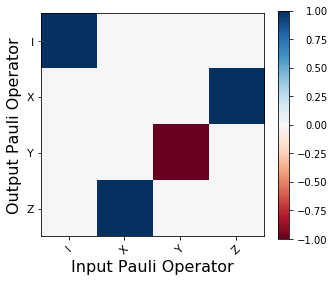

In [13]:
f, (ax1) = plt.subplots(1, 1, figsize=(5, 4.2))

plot_pauli_transfer_matrix(Hpaulirep,ax=ax1)

The above figure is a graphical representation of:
    
(out operator) = H (in operator) H

Z = H X H  
-Y = H Y H  
X = H Z H  

### Evolving states using quantum channels

In many superoperator representations evolution corresponds to multiplying the vec'ed state by the superoperator. E.g.

In [14]:
from forest.benchmarking.operator_tools import kraus2superop

zero_state_vec = vec(zero_state)

answer_vec = np.matmul(kraus2superop([H]), zero_state_vec)

print('The vec\'ed answer is', answer_vec)
print('\n')
print('The unvec\'ed answer is\n', np.real(unvec(answer_vec)))
print('\n')
print('Let\'s compare it to the normal calculation\n', H @ zero_state @ H)

The vec'ed answer is [[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]]


The unvec'ed answer is
 [[0.5 0.5]
 [0.5 0.5]]


Let's compare it to the normal calculation
 [[0.5 0.5]
 [0.5 0.5]]


For representations with this simple application there are no inbuilt functions in forest benchmarking. 

However applying a channel is more painful in the Choi and Kraus representation.

Consider the amplitude damping channel where we need to perform the following calculation to find out put of channel 
$\rho_{out} = A_0 \rho A_0^\dagger + A_1 \rho A_1^\dagger$.
We provide helper functions to do these calculations.

In [15]:
from forest.benchmarking.operator_tools import apply_kraus_ops_2_state, apply_choi_matrix_2_state, kraus2choi

In [16]:
apply_kraus_ops_2_state(AD_kraus, one_state)

array([[0.1, 0. ],
       [0. , 0.9]])

In the Choi representation we get the same answer:

In [17]:
AD_choi = kraus2choi(AD_kraus)

apply_choi_matrix_2_state(AD_choi, one_state)

array([[0.1, 0. ],
       [0. , 0.9]])

### Compose quantum channels

Composing channels is useful when describing larger circuits. In some representations e.g. in the superoperator  or Liouville representation it is just matrix multiplication e.g.

In [18]:
from forest.benchmarking.operator_tools import superop2kraus, kraus2superop

In [19]:
H_super = kraus2superop(H)

H_squared_super = H_super @ H_super

print('Hadamard squared as a superoperator:\n', np.round(H_squared_super,2))

print('\n As a Kraus operator:\n', np.round(superop2kraus(H_squared_super),2))

Hadamard squared as a superoperator:
 [[ 1.+0.j -0.+0.j -0.+0.j  0.+0.j]
 [-0.+0.j  1.+0.j  0.+0.j -0.+0.j]
 [-0.+0.j  0.+0.j  1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  1.+0.j]]

 As a Kraus operator:
 [[[ 1.+0.j -0.+0.j]
  [ 0.+0.j  1.+0.j]]]


Composing channels in the Kraus representation is more difficult. Consider composing two channels $\mathcal A$ (with Kraus operators $[A_0, A_1]$) and $\mathcal B$ (with Kraus operators $[B_0, B_1]$). The composition is 

$$\begin{align}
\mathcal B(\mathcal A(\rho)) & = \sum_i \sum_j B_j A_i \rho A_i^\dagger B_j^\dagger 
\end{align}$$

In [20]:
from forest.benchmarking.operator_tools import compose_channel_kraus, superop2kraus

In [21]:
BitFlip_kraus = bit_flip_kraus(0.2)

kraus2superop(compose_channel_kraus(AD_kraus, BitFlip_kraus))

array([[0.82      +0.j, 0.        +0.j, 0.        +0.j, 0.28      +0.j],
       [0.        +0.j, 0.75894664+0.j, 0.18973666+0.j, 0.        +0.j],
       [0.        +0.j, 0.18973666+0.j, 0.75894664+0.j, 0.        +0.j],
       [0.18      +0.j, 0.        +0.j, 0.        +0.j, 0.72      +0.j]])

This is the same as if we do

In [22]:
BitFlip_super = kraus2superop(BitFlip_kraus)
AD_super = kraus2superop(AD_kraus)

AD_super @ BitFlip_super

array([[0.82      +0.j, 0.        +0.j, 0.        +0.j, 0.28      +0.j],
       [0.        +0.j, 0.75894664+0.j, 0.18973666+0.j, 0.        +0.j],
       [0.        +0.j, 0.18973666+0.j, 0.75894664+0.j, 0.        +0.j],
       [0.18      +0.j, 0.        +0.j, 0.        +0.j, 0.72      +0.j]])

We can also easily compose channels acting on independent spaces.

Consider composing the same two channels as above, $\mathcal A$ and $\mathcal B$. However this time they act on different Hilbert spaces. With respect to the tensor product structure $H_2 \otimes H_1$ the Kraus operators are $[A_0\otimes I, A_1\otimes I]$ and $[I \otimes B_0, I \otimes B_1]$.

In this case the order of the operations commutes 

$$\begin{align}
\mathcal A(\mathcal B(\rho))= \mathcal B(\mathcal A(\rho)) & = \sum_i \sum_j  A_i\otimes B_j \rho A_i^\dagger\otimes B_j^\dagger 
\end{align}$$

In forest benchmarking you can specify the two channels without the Identity tensored on and it will take care of it for you:

In [23]:
from forest.benchmarking.operator_tools import tensor_channel_kraus

In [24]:
np.round(tensor_channel_kraus(AD_kraus,BitFlip_kraus),3)

array([[[0.894, 0.   , 0.   , 0.   ],
        [0.   , 0.894, 0.   , 0.   ],
        [0.   , 0.   , 0.849, 0.   ],
        [0.   , 0.   , 0.   , 0.849]],

       [[0.   , 0.   , 0.283, 0.   ],
        [0.   , 0.   , 0.   , 0.283],
        [0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   ]],

       [[0.   , 0.447, 0.   , 0.   ],
        [0.447, 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.424],
        [0.   , 0.   , 0.424, 0.   ]],

       [[0.   , 0.   , 0.   , 0.141],
        [0.   , 0.   , 0.141, 0.   ],
        [0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   ]]])

### Validate quantum channels are physical

When doing process tomography sometimes the estimates returned by various estimation methods can result in unphysical processes.

The functions below can be used to check if the estimates are physical.


As a starting point, we might want to check if a process specified by Kraus operators is valid. 

Unless a process is unitary you need more than one Kraus operator to be a valid quantum operation.

In [25]:
from forest.benchmarking.operator_tools import kraus_operators_are_valid

kraus_operators_are_valid(AD_kraus[0])

False

However a full set is valid:

In [26]:
kraus_operators_are_valid(AD_kraus)

True

We can also validate other properties of quantum channels such as completely positivity and trace preservation. This is done on the **Choi** representation, so you many need to convert your quantum operation to the Choi representation first.


In [27]:
from forest.benchmarking.operator_tools import (choi_is_unitary, 
                                                choi_is_unital, 
                                                choi_is_trace_preserving, 
                                                choi_is_completely_positive, 
                                                choi_is_cptp)

In [28]:
# amplitude damping is not unitary
print(choi_is_unitary(AD_choi),'\n')

# amplitude damping is not unital
print(choi_is_unital(AD_choi))

False 

False


In [29]:
# amplitude damping is trace preserving (TP)
print(choi_is_trace_preserving(AD_choi),'\n')

# amplitude damping is completely positive (CP)
print(choi_is_completely_positive(AD_choi), '\n')

# amplitude damping is CPTP
print(choi_is_cptp(AD_choi))

True 

True 

True


### Project an unphysical state to the closest physical state

In [30]:
from forest.benchmarking.operator_tools.project_state_matrix import project_state_matrix_to_physical

In [31]:
# Test the method. Example from fig 1 of maximum likelihood minimum effort 
# https://doi.org/10.1103/PhysRevLett.108.070502

eigs = np.diag(np.array(list(reversed([3.0/5, 1.0/2, 7.0/20, 1.0/10, -11.0/20]))))
phys = project_state_matrix_to_physical(eigs)
np.allclose(phys, np.diag([0, 0, 1.0/5, 7.0/20, 9.0/20]))

True

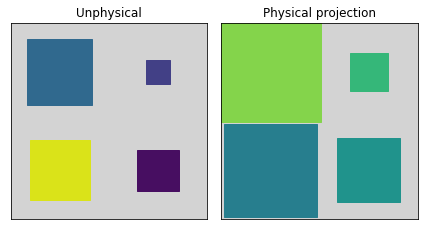

In [32]:
from forest.benchmarking.plotting import hinton

rho_unphys = np.random.uniform(-1, 1, (2, 2)) \
    * np.exp(1.j * np.random.uniform(-np.pi, np.pi, (2, 2)))
rho_phys = project_state_matrix_to_physical(rho_unphys)

fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_unphys, ax=ax1)
hinton(rho_phys, ax=ax2)
ax1.set_title('Unphysical')
ax2.set_title('Physical projection')
fig.tight_layout()

### Project unphysical channels to physical channels

When doing process tomography often the estimates returned by maximum likelihood estimation or linear inversion methods can result in unphysical processes.

The functions below can be used to project the unphysical estimates back to physical estimates.

In [33]:
from forest.benchmarking.operator_tools.project_superoperators import (proj_choi_to_completely_positive,
                                                                       proj_choi_to_trace_non_increasing,
                                                                       proj_choi_to_trace_preserving,
                                                                       proj_choi_to_physical,
                                                                       proj_choi_to_unitary)

In [34]:
neg_Id_choi = -kraus2choi(I)

In [35]:
proj_choi_to_completely_positive(neg_Id_choi)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [36]:
proj_choi_to_trace_non_increasing(neg_Id_choi)

array([[-1., -0., -0., -1.],
       [-0., -0., -0., -0.],
       [-0., -0., -0., -0.],
       [-1., -0., -0., -1.]])

In [37]:
proj_choi_to_trace_preserving(neg_Id_choi)

array([[ 0.,  0., -0., -1.],
       [ 0.,  1., -0., -0.],
       [-0., -0.,  1.,  0.],
       [-1., -0.,  0.,  0.]])

In [38]:
proj_choi_to_physical(neg_Id_choi)

array([[ 0.33398438,  0.        ,  0.        , -0.33203125],
       [ 0.        ,  0.66601562,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.66601562,  0.        ],
       [-0.33203125,  0.        ,  0.        ,  0.33398438]])

In [39]:
# closer to identity
proj_choi_to_unitary(kraus2choi(bit_flip_kraus(0.1)))

array([[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [40]:
# closer to X gate
proj_choi_to_unitary(kraus2choi(bit_flip_kraus(0.9)))

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

### Validate operators

A lot of the work in validating the physicality of quantum channels comes down to validating properties of matrices:

In [41]:
from forest.benchmarking.operator_tools.validate_operator import (is_square_matrix, 
                                                                  is_identity_matrix, 
                                                                  is_idempotent_matrix, 
                                                                  is_unitary_matrix, 
                                                                  is_positive_semidefinite_matrix)

In [42]:
# a vector is not square
is_square_matrix(np.array([[1], [0]]))

False

In [43]:
# NBVAL_RAISES_EXCEPTION
# the line above is for testing purposes, do not remove.

# a tensor is not a matrix

tensor = np.ones(8).reshape(2,2,2)
print(tensor)

is_square_matrix(tensor)

[[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]]


ValueError: The object is not a matrix.

In [44]:
is_identity_matrix(X)

False

In [45]:
projector_zero = np.array([[1, 0], [0, 0]])

is_idempotent_matrix(projector_zero)

True

In [46]:
is_unitary_matrix(AD_kraus[0])

False

In [47]:
is_positive_semidefinite_matrix(I)

True